# Custom Autograd Engine in PyTorch

This notebook implements a custom Swish activation function using PyTorch's `autograd.Function`. 
It includes:
1. Definition of the custom `SwishFunction` and `Swish` module.
2. Numerical gradient checking to validate the backward pass.
3. Integration into a simple neural network with a training loop and loss visualization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import gradcheck
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Custom Swish Activation Function

Here we define the `SwishFunction` which inherits from `torch.autograd.Function`. 
We implement both `forward` and `backward` static methods.

$$ f(x) = x \cdot \sigma(x) $$
$$ f'(x) = \sigma(x) + f(x) \cdot (1 - \sigma(x)) $$

In [2]:
class SwishFunction(torch.autograd.Function):
    """
    Custom Autograd Function for Swish activation.
    Swish(x) = x * sigmoid(x)
    """
    @staticmethod
    def forward(ctx, input):
        """
        Forward pass for Swish.
        """
        ctx.save_for_backward(input)
        sigmoid = torch.sigmoid(input)
        output = input * sigmoid
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass for Swish.
        Computes the gradient of the loss with respect to the input.
        Derivative of Swish: f'(x) = sigmoid(x) + f(x) * (1 - sigmoid(x))
        """
        input, = ctx.saved_tensors
        sigmoid = torch.sigmoid(input)
        output = input * sigmoid
        
        # Calculate gradient
        grad_input = grad_output * (sigmoid + output * (1 - sigmoid))
        return grad_input

class Swish(torch.nn.Module):
    """
    Swish module to be used in neural networks.
    """
    def forward(self, input):
        return SwishFunction.apply(input)

## 2. Gradient Check

We use `torch.autograd.gradcheck` to compare the analytical gradient (computed by our `backward` method) against a numerical gradient computed via finite differences.

In [3]:
def check_swish_gradient():
    print("Running gradient check for SwishFunction...")
    
    # Create a random input tensor with double precision for numerical stability during gradcheck
    # requires_grad=True is essential for autograd
    input = (torch.randn(20, 20, dtype=torch.double, requires_grad=True),)
    
    # gradcheck compares the analytical gradient (calculated by our backward method)
    # with the numerical gradient (calculated by finite differences).
    try:
        test = gradcheck(SwishFunction.apply, input, eps=1e-6, atol=1e-4)
        print(f"Gradient check passed: {test}")
    except Exception as e:
        print(f"Gradient check failed: {e}")

check_swish_gradient()

Running gradient check for SwishFunction...
Gradient check passed: True


## 3. Training Loop & Visualization

We create a simple neural network `SimpleNet` that uses our custom `Swish` layer, train it, and plot the loss curve.

Starting training with Custom Swish Activation...
----------------------------------------
Epoch [10/100], Loss: 1.0425
Epoch [20/100], Loss: 1.0190
Epoch [30/100], Loss: 1.0049
Epoch [40/100], Loss: 0.9959
Epoch [50/100], Loss: 0.9897
Epoch [60/100], Loss: 0.9851
Epoch [70/100], Loss: 0.9814
Epoch [80/100], Loss: 0.9783
Epoch [90/100], Loss: 0.9755
Epoch [100/100], Loss: 0.9730
----------------------------------------
Training complete.


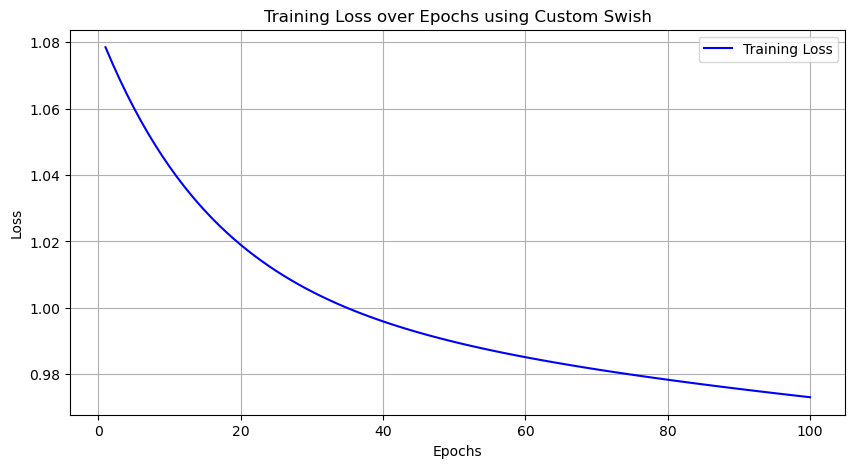

In [4]:
# Define a small neural network using the custom Swish operation
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.swish = Swish() # Using our custom Swish layer
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.swish(x)
        x = self.fc2(x)
        return x

def train_and_plot():
    # Hyperparameters
    input_size = 10
    hidden_size = 20
    output_size = 1
    learning_rate = 0.01
    num_epochs = 100

    # Dummy data
    inputs = torch.randn(100, input_size)
    targets = torch.randn(100, output_size)

    # Model, Loss, Optimizer
    model = SimpleNet(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print("Starting training with Custom Swish Activation...")
    print("-" * 40)
    
    loss_history = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print("-" * 40)
    print("Training complete.")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs using Custom Swish')
    plt.legend()
    plt.grid(True)
    plt.show()

train_and_plot()